# Lab 1: Day-ahead load prediction for ERCOT (Texas) markets. 

In this lab, you train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

## Load the ERCOT data from 2015.

The load data is given in the column named 'ERCOT Load, MW' in the csv file provided.

In [2]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


## Understand the data.

It is always useful to get accustomed to the data you are trying to learn. Visualize it if you can.

#### Q1. How does load vary over the year in Texas?

Text(0,0.5,'Net demand of Texas (in MW)')

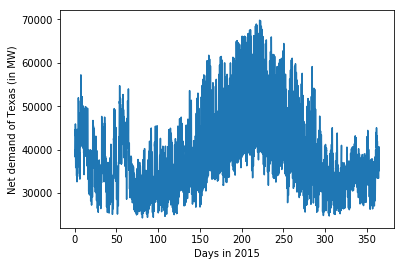

In [3]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (5 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**Your answer.** It's pretty hot in the summer, since people use for electricity in summer for the air conditioner. I'm expected lower in summer and higher in winter if I plot in Illinois, because it is okay in summer but super cold in winter. 


#### Q2. How does day of week affect the load profiles?

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


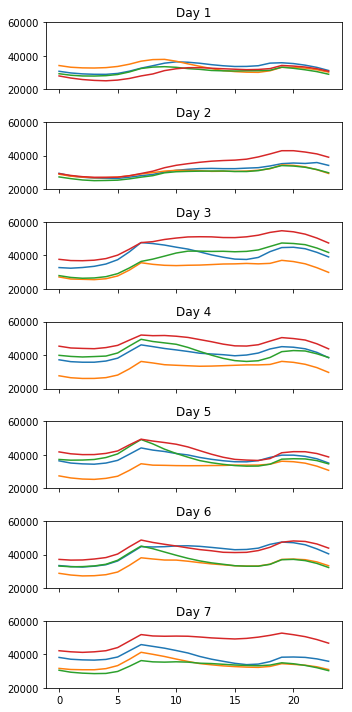

In [4]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (5 points).** Can you find any discernible change in the load profiles of different days of the week?

**Your answer.** During the weekdays, people cost more electricity. And during the weekdays, people stay at home with family, and don't use much energy.

**Question (15 points).** Redo the above exercise for the month of August. Make 'Day 1' correspond to August 15th. What do you observe differently? Do your observations agree with Q1? 

**Your answer (comments here, code below).** People use more electricity in summer, because it's too hot in summer. My observation agree with Q1.

The first day in the first plot is Aug 15, 2015.
Day 1 was a Saturday.


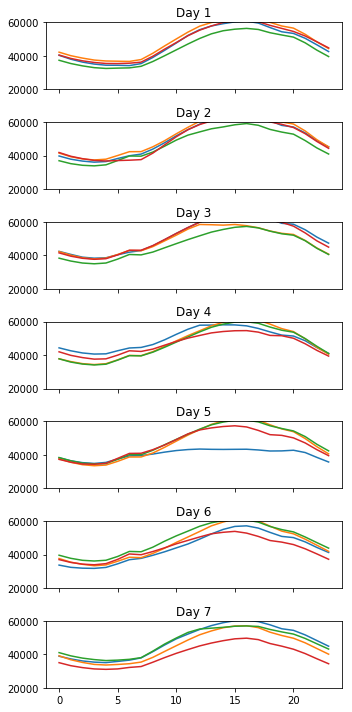

In [18]:

dayStart = 227
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Aug 15, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [12]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]


When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [13]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

Recall that TensorFlow defines a computation graph where the weights and biases associated with the NN are variables. The goal is to optimize the weights and biases of the NN to minimize prediction error using data. 


To define the computation graph, create the inputs and outputs as 'placeholders'.
The algorithm only expects them to be specified at the time of computation. The
first element of the shape attribute for both inputs and outputs are 'None'. This
means that they are left unspecified, and will be provided at runtime. It will help
in batch training for prediction, where the size of the batch will determine
this value. Batch training is useful because training the NN with one data point at a
time can be time consuming.

In this lab, we begin with a 'relu' activation. We additionally implement 'dropouts' that basically
prevents certain paramters from updating in each round. This is known to prevent overfitting. The number'0.995' in the description below updates 99.5% of all weights, leaving out 0.5%.

Design the optimizer and the loss. For reporting the accuracy of prediction, we choose in this lab the idea of mean absolute error (MAE). For a data set, if the true values are scalars $y_1, \ldots, y_m$ and the predictions are $\hat{y}_1, \ldots, \hat{y}_m$, then its MAE is given by
$$ MAE = \frac{1}{m}\sum|y_i - \hat{y}_i|.$$
If $y$ and $\hat{y}$ are multidimensional, it computes the average across each coordinate of $y$ and $\hat{y}$.

**Question (5 points). Insert a line of code for the output of layer 1 below (use the relu function)** 

In [19]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the inputs and the target outputs for the NN.
inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])

# Define the weights and biases of the first layer.
W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.zeros(nHidden))

# Define the output of layer 1. 
## use the function 'tf.nn.relu' to define 'OutputLayer1'.  

# ....
outputLayer1 = tf.nn.relu(tf.matmul(inputNN, W1) + b1)

outputLayer1 = tf.nn.dropout(outputLayer1, 0.995)

# Define the weights and biases of the second layer.
W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.zeros(nDimY))

# Define the output of layer 2.
outputNN = tf.nn.dropout((tf.matmul(outputLayer1, W2) + b2), 0.995)

# Define the loss function and the optimizer.
loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.25).minimize(loss)

# Compute the MAE metric to judge accuracy of prediction.
_, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)


### Train the neural network.

Create the training module for the NN. Feed the training data in batches of size 'batchSize'
and ask Tensorflow to run the function 'optimizer'. The number of batches, denoted by 'nBatches'
is then given by the size of your training dataset divided by 'batchSize. Usually, going through
the training data once does not train your NN. You train over the same data multiple
times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn
a material by reading through it once!

In [20]:
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 5000

# Define a session.
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph.
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")

    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]

            # Run the optimizer, and specify the placeholders with the inputs and
            # target outputs from the batch.
            _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
            # Keep track of the total loss over an entire epoch.
            lossEpoch += lossBatch

        if (epoch + 1) % 200 == 0:
            # Output the loss over an epoch, every few epochs or so.
            print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch + 1, lossEpoch/nBatches))

    print("Training process completed.")

Started the training module.
Epoch: 200 - Average loss in last epoch = 96211188.8
Epoch: 400 - Average loss in last epoch = 49190219.2
Epoch: 600 - Average loss in last epoch = 41651693.6
Epoch: 800 - Average loss in last epoch = 31835607.6
Epoch: 1000 - Average loss in last epoch = 28676611.6
Epoch: 1200 - Average loss in last epoch = 26214886.4
Epoch: 1400 - Average loss in last epoch = 24368710.4
Epoch: 1600 - Average loss in last epoch = 22137959.6
Epoch: 1800 - Average loss in last epoch = 17913101.4
Epoch: 2000 - Average loss in last epoch = 18530954.6
Epoch: 2200 - Average loss in last epoch = 18087926.6
Epoch: 2400 - Average loss in last epoch = 15161165.6
Epoch: 2600 - Average loss in last epoch = 17463604.8
Epoch: 2800 - Average loss in last epoch = 14245585.8
Epoch: 3000 - Average loss in last epoch = 17075068.6
Epoch: 3200 - Average loss in last epoch = 17546986.0
Epoch: 3400 - Average loss in last epoch = 13742747.0
Epoch: 3600 - Average loss in last epoch = 15883887.0
Epo

### Test the accuracy of prediction via NN.

Here, you report the mean absolute error of your predictions over the 'testX' dataset. Finally, plot the actual demand profile versus the predicted demand profile for a few days from the test data.

In [21]:
    predictedY, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
    print("Mean absolute error of forecast = ", maeOfPrediction)

Mean absolute error of forecast =  2390.8271


**Question (5 points).** Comment whether your MAE is high or low.

**Hint.** Compare the mean absolute error to the maximum demands.

**Your answer.** MAE is low, because it is pretty small comparing to the maximum demands.

### Let us visualize the results.


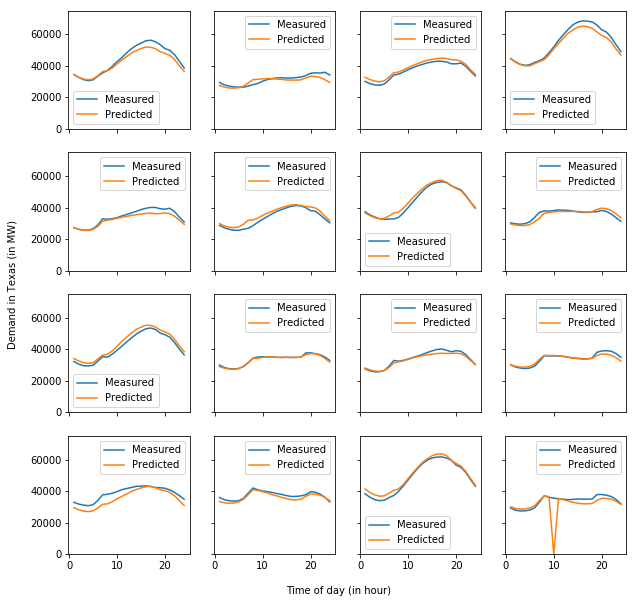

In [22]:
    # Plot the predicted load and compare against the actual load from the test data.
    assert(nTest >= 16)
    days = random.sample(range(nTest), 16)

    fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
    axs = axs.ravel()

    for dd, day in enumerate(days):
        testYDay = testY[day]
        predictedYDay = predictedY[day]

        l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
        l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
        
        axs[dd].set_ylim(bottom=0, top=75000)
        axs[dd].legend()
    
    fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
    fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')
    
    plt.show()

**Question (20 points).** Explore how the number of epochs affects the accuracy and speed of training. Start with 10 epochs, and increase it to 100, 1000, 5000, 10000, and maybe more (do not exceed 20000 unless you have a powerful computer, you are only required to do up to 10000 for this lab). Make comments based on your observations. As an engineer, what is your favorite number of epochs, and why? 

**Your answer.** The larger the number of epoche, the smaller the loss is, which means the accuracy improves. My favorite number of epochs is 5000, because it is already pretty actuate and won't take me too much time.

**Question (20 points).** Fix the number of echos to your favorite one, and then explore how the number of neurons affects the accuracy and speed of training. Start with 6 , and increase it to 12, 24, 48, 100, and more. Make comments based on your observations. As an engineer, what is your favorite number of neurons, and why? 

**Your answer.** The larger the number of neurons, the more accuracy we have and the slower the training is. my favorit number of neurons is 200, since it has the best accuracy.

**Question (30 points).** Fix the number of epochs and neurons to your favorite ones. Then, add another layer to the network. Discuss what your observe in terms of speed and accuracy. If the training becomes too slow, you may alter the number of epochs/neurons. 
The speed is slow, but I have a pretty low average loss and a pretty low ABE, which is about 1900.

**Your answer (comments here, code below). Your code should show the results for the 2 layers case. Go back to the codes above for the 1 layer case and run it again for the same number of epochs/neurons**

In [36]:
batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 10001

# Define a session.
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph.
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")

    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]

            # Run the optimizer, and specify the placeholders with the inputs and
            # target outputs from the batch.
            _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
            # Keep track of the total loss over an entire epoch.
            lossEpoch += lossBatch

        if ((epoch + 1 == 11) or (epoch + 1 == 101) or (epoch + 1 == 501) or (epoch + 1 == 1001) or (epoch + 1 == 5001) or (epoch + 1 == 10001)):
            # Output the loss over an epoch, every few epochs or so.
            print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch , lossEpoch/nBatches))

    print("Training process completed.")

Started the training module.
Epoch: 10 - Average loss in last epoch = 307968057.6
Epoch: 100 - Average loss in last epoch = 203425299.2
Epoch: 500 - Average loss in last epoch = 48724164.0
Epoch: 1000 - Average loss in last epoch = 30897307.6
Epoch: 5000 - Average loss in last epoch = 15868421.4
Epoch: 10000 - Average loss in last epoch = 14235074.4
Training process completed.


In [40]:
listHidden = {6,12,24,48,100,150,200}
for nHidden in listHidden:
    # Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
    nDimX = np.shape(trainX)[1]
    nDimY = np.shape(trainY)[1]
    
    # Define the inputs and the target outputs for the NN.
    inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
    targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])
    
    # Define the weights and biases of the first layer.
    W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
    b1 = tf.Variable(tf.zeros(nHidden))
    
    # Define the output of layer 1. 
    ## use the function 'tf.nn.relu' to define 'OutputLayer1'.  
    
    # ....
    outputLayer1 = tf.nn.relu(tf.matmul(inputNN, W1) + b1)
    
    outputLayer1 = tf.nn.dropout(outputLayer1, 0.995)
    
    # Define the weights and biases of the second layer.
    W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nDimY]))
    b2 = tf.Variable(tf.zeros(nDimY))
    
    # Define the output of layer 2.
    outputNN = tf.nn.dropout((tf.matmul(outputLayer1, W2) + b2), 0.995)
    
    # Define the loss function and the optimizer.
    loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
    optimizer = tf.train.AdagradOptimizer(learning_rate=0.25).minimize(loss)
    
    # Compute the MAE metric to judge accuracy of prediction.
    _, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)
    
    
    batchSize = 50
    nBatches = int(nTrain/batchSize)
    nEpochs = 5001
    
    # Define a session.
    sess = tf.Session()
    with sess.as_default():
    
        # Initialize the computation graph.
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())
        
        print("Started the training module with nhidden: ", nHidden)
    
        for epoch in range(nEpochs):
    
            lossEpoch = 0
            # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
            for n in range(nBatches):
                # Define the batch to train on.
                batchX = trainX[n * batchSize: (n + 1) * batchSize]
                batchY = trainY[n * batchSize: (n + 1) * batchSize]
    
                # Run the optimizer, and specify the placeholders with the inputs and
                # target outputs from the batch.
                _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
                # Keep track of the total loss over an entire epoch.
                lossEpoch += lossBatch
    
            if ((epoch + 1 == 5001)):
                # Output the loss over an epoch, every few epochs or so.
                print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch , lossEpoch/nBatches))
    
        print("Training process completed.")

Started the training module with nhidden:  100
Epoch: 5000 - Average loss in last epoch = 14657830.8
Training process completed.
Started the training module with nhidden:  6
Epoch: 5000 - Average loss in last epoch = 146871313.6
Training process completed.
Started the training module with nhidden:  200
Epoch: 5000 - Average loss in last epoch = 11662552.4
Training process completed.
Started the training module with nhidden:  12
Epoch: 5000 - Average loss in last epoch = 56812844.0
Training process completed.
Started the training module with nhidden:  48
Epoch: 5000 - Average loss in last epoch = 20209153.2
Training process completed.
Started the training module with nhidden:  150
Epoch: 5000 - Average loss in last epoch = 13747642.4
Training process completed.
Started the training module with nhidden:  24
Epoch: 5000 - Average loss in last epoch = 32590807.2
Training process completed.


In [39]:
print("nDimX", np.shape(trainX)[1])
print("nDimY", np.shape(trainY)[1])

nDimX 72
nDimY 24


In [42]:
nHidden = 200

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the inputs and the target outputs for the NN.
inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])

# Define the weights and biases of the first layer.
W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.zeros(nHidden))

# Define the output of layer 1. 
## use the function 'tf.nn.relu' to define 'OutputLayer1'.  

# ....
outputLayer1 = tf.nn.relu(tf.matmul(inputNN, W1) + b1)

outputLayer1 = tf.nn.dropout(outputLayer1, 0.995)

# Define the weights and biases of the second layer.
W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.zeros(nDimY))

# Define the output of layer 2.
outputLayer2 = tf.nn.dropout((tf.matmul(outputLayer1, W2) + b2), 0.995)

# Define the weights and biases of the third layer.
W3 = tf.Variable(tf.truncated_normal(shape=[nDimY, nDimY]))
b3 = tf.Variable(tf.zeros(nDimY))

# Define the output of layer 2.
outputNN = tf.nn.dropout((tf.matmul(outputLayer2, W3) + b3), 0.995)

# Define the loss function and the optimizer.
loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.25).minimize(loss)

# Compute the MAE metric to judge accuracy of prediction.
_, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)

batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 5001

# Define a session.
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph.
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")

    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]

            # Run the optimizer, and specify the placeholders with the inputs and
            # target outputs from the batch.
            _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
            # Keep track of the total loss over an entire epoch.
            lossEpoch += lossBatch

        if ((epoch + 1 == 5001)):
            # Output the loss over an epoch, every few epochs or so.
            print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch , lossEpoch/nBatches))

    print("Training process completed.")
predictedY, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
print("Mean absolute error of forecast = ", maeOfPrediction)

Started the training module.
Epoch: 5000 - Average loss in last epoch = 11396633.0
Training process completed.
Mean absolute error of forecast =  1942.2611


### The effect of wind energy (bonus).

In [74]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8
5,1/1/15 5:00,1-Jan,38877,745,12730,1.9,5.9,94.0,14.5
6,1/1/15 6:00,1-Jan,39837,788,12730,2.0,6.2,43.0,5.8
7,1/1/15 7:00,1-Jan,40520,758,12730,1.9,6.0,-30.0,-3.8
8,1/1/15 8:00,1-Jan,41008,668,12730,1.6,5.2,-90.0,-11.8
9,1/1/15 9:00,1-Jan,42052,496,12730,1.2,3.9,-172.0,-25.8


Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why? Write down your MAE before and after considering wind energy. 

**Your answer (comments here, code below).** The accuracy is went down a little bit after subtracting the wind data. My MAE before is 1942.2611 and MAE after is 2488.4133. Because wind is hard to predict.

In [75]:
loaddata = dfDemand['ERCOT Load, MW']
winddata = dfDemand['Wind Output, % of Load']
demands = loaddata- winddata

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


Text(0,0.5,'Net demand of Texas (in MW)')

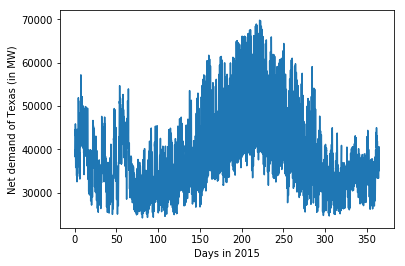

In [79]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

In [82]:
#print the MAE before considering wind energy
predictedY, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
print("Mean absolute error of forecast = ", maeOfPrediction)


# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)

daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)
X = [np.concatenate([demands[(day + h) * 24: (day + h + 1) * 24 -1].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [demands[day * 24: (day + 1) * 24 - 1].values.flatten() for day in rangeOfDays]


X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)
print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]
print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))



Mean absolute error of forecast =  3205.2024
Hourly demand data loaded for 365 days.
Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


In [83]:
nHidden = 200

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Define the inputs and the target outputs for the NN.
inputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimX])
targetOutputNN = tf.placeholder(dtype=tf.float32, shape=[None, nDimY])

# Define the weights and biases of the first layer.
W1 = tf.Variable(tf.truncated_normal(shape=[nDimX, nHidden]))
b1 = tf.Variable(tf.zeros(nHidden))

# Define the output of layer 1. 
## use the function 'tf.nn.relu' to define 'OutputLayer1'.  

# ....
outputLayer1 = tf.nn.relu(tf.matmul(inputNN, W1) + b1)

outputLayer1 = tf.nn.dropout(outputLayer1, 0.995)

# Define the weights and biases of the second layer.
W2 = tf.Variable(tf.truncated_normal(shape=[nHidden, nDimY]))
b2 = tf.Variable(tf.zeros(nDimY))

# Define the output of layer 2.
outputLayer2 = tf.nn.dropout((tf.matmul(outputLayer1, W2) + b2), 0.995)

# Define the weights and biases of the third layer.
W3 = tf.Variable(tf.truncated_normal(shape=[nDimY, nDimY]))
b3 = tf.Variable(tf.zeros(nDimY))

# Define the output of layer 2.
outputNN = tf.nn.dropout((tf.matmul(outputLayer2, W3) + b3), 0.995)

# Define the loss function and the optimizer.
loss = tf.losses.mean_squared_error(labels=targetOutputNN, predictions=outputNN)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.25).minimize(loss)

# Compute the MAE metric to judge accuracy of prediction.
_, maeY = tf.metrics.mean_absolute_error(labels=targetOutputNN, predictions=outputNN)

batchSize = 50
nBatches = int(nTrain/batchSize)
nEpochs = 5001

# Define a session.
sess = tf.Session()
with sess.as_default():

    # Initialize the computation graph.
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    print("Started the training module.")

    for epoch in range(nEpochs):

        lossEpoch = 0
        # In each epoch, use 'optimizer' to reduce the 'loss' over batches of data.
        for n in range(nBatches):
            # Define the batch to train on.
            batchX = trainX[n * batchSize: (n + 1) * batchSize]
            batchY = trainY[n * batchSize: (n + 1) * batchSize]

            # Run the optimizer, and specify the placeholders with the inputs and
            # target outputs from the batch.
            _, lossBatch = sess.run([optimizer, loss], feed_dict={inputNN: batchX, targetOutputNN: batchY})
            # Keep track of the total loss over an entire epoch.
            lossEpoch += lossBatch

        if ((epoch + 1 == 5001)):
            # Output the loss over an epoch, every few epochs or so.
            print("Epoch: %d - Average loss in last epoch = %1.1f" % (epoch , lossEpoch/nBatches))

    print("Training process completed.")
predictedY, maeOfPrediction = sess.run([outputNN, maeY], feed_dict={inputNN: testX, targetOutputNN: testY})
print("Mean absolute error of forecast = ", maeOfPrediction)

Started the training module.
Epoch: 5000 - Average loss in last epoch = 11771285.1
Training process completed.
Mean absolute error of forecast =  2488.4133
